


# ***Click Prediction using Convolutional Neural Networks***

----

# Abstract

In online advertising, predicting whether a user will click on an ad is crucial for optimizing ad placement and maximizing revenue. In this project, we propose a novel approach to click prediction using Convolutional Neural Networks (CNNs). We use three datasets: the groundtruth dataset containing information about ad clicks, the participants dataset containing information about ad characteristics and user interactions, and the user behavior dataset containing detailed user interactions on a webpage. By merging these datasets, we create a comprehensive dataset for training our CNN model.

We preprocess the data and reshape it to fit the CNN input shape. We then build and train a CNN model using Keras with TensorFlow backend. The model learns to extract relevant features from the user behavior data and predicts whether a user will click on an ad. We evaluate the model using standard classification metrics such as accuracy, precision, recall, and F1-score.

Our experimental results demonstrate that the proposed CNN model outperforms traditional machine learning models for click prediction. The model's ability to learn from raw user behavior data makes it a promising approach for click prediction in online advertising.

# Table of Contents

1. Data Collection
    1. Groundtruth Dataset
    2. Participants Dataset
    3. User Behavior Dataset
        - Extract width and height of web page
        - Load CSV file into pandas dataframe
        - Extract Time Spent And Date
        - Temporal Features
        - Extract CSV data consist of User Behavior

2. Data Preprocessing
    1. Merge Data frames
    2. Country Parameter
    3. Category Parameter
    4. Convert Categorical Values To Numeral Values
    5. Check For Missing Values
    6. Filter Data Based On Time Spent
    7. Check Value Count Ad Click

3. Feature Selection
    1. Remove Unnecessary Columns
    2. Correlation Between Features
    3. Correlation Between Features And Target
    4. Mutual Information

4. Machine Learning
    1. Functions
        - Confusion plot function
        - AUC curve plot function

    2. One Hot Encoding
    3. Data Train/Test Split
    4. Data Scaling
    5. Naive Bayes
    6. Random Forest Classifier
    7. Logistic Regression Model
    8. Support Vector Regression (SVR) 
    9. Convolutional Neural Network Model
        - Plot Learning Curve

5. Evaluation

----
# 1. Data Collection
## 1.1 Groundtruth Dataset

This dataset contains information about ad clicks. It includes whether a user clicked on an ad or not (ad_clicked) and a unique identifier for each log entry (log_id).

Based on the definition of the project, a series of data cannot be used in the project. We will remove them at this initial stage, although some of them could have effective parameters in the prediction.

***Parameters :***
- `ad_clicked`: (int) Whether the participant clicked on the ad (1) or not (0).
- `log_id`: (string) Mouse tracking log ID.


In [147]:
# Read the dataframe in pandas format
import pandas as pd

groundtruth = pd.read_csv("groundtruth.tsv", delimiter="\t")
groundtruth = groundtruth.drop(["attention","user_id"], axis=1)
groundtruth.head(3) 

,ad_clicked,log_id
0,0,20181002033126
1,1,20181001211223
2,0,20181001170952


## 1.2 Participants Dataset
This dataset contains information about ad characteristics and user interactions. It includes details such as the country of the participant (country), ad position (ad_position), ad type (ad_type), ad category (ad_category), SERP (Search Engine Results Page) ID (serp_id), search query (query), and a unique identifier for each log entry (log_id).

***Parameters***
- `country`: (string) Participant's country, in ISO-3 format.

- `ad_position`: (string) Ad stimulus position.

- `ad_type`: (string) Ad stimulus type.

- `ad_category`: (string) Ad stimulus category.

- `serp_id`: (string) Ad SERP identifier.

- `query`: (string) Ad stimulus query.

- `log_id`: (string) Mouse tracking log ID.

In [148]:
participants = pd.read_csv("participants.tsv", delimiter="\t")
participants = participants.drop(["user_id","education","age","income","gender"], axis=1)
participants.head(3)

,country,ad_position,ad_type,ad_category,serp_id,query,log_id
0,PHL,top-left,dd,Computers & Electronics,tablets,tablets,20181002033126
1,VEN,top-right,dd,Shop - Luxury Goods,casio-watches,casio watches,20181001211223
2,VEN,top-left,native,Shop - Luxury Goods,chivas-regal,chivas regal,20181001170952


## 1.3 User Behavior Dataset
This dataset contains detailed user interactions on a webpage. It includes information such as cursor timestamp (cursor), timestamp (timestamp), cursor position (xpos and ypos), event type (event), XPath of the element (xpath), attributes of the element (attrs), and extra information about the event (extras). The unique identifier for each log entry is the name of the file (log_id).

We store this information in the log folder in the ‍‍`user_behavior` data frame.

- ### `Extract width and height of web page`

In the XML file, there is information about the width and length of the document, which we need for normalization. On the other hand, it is better to include this parameter to make each point similar.

In [149]:
import xml.etree.ElementTree as ET

user_behavior = pd.DataFrame(participants["log_id"])

user_behavior["doc_width"] = 0
user_behavior["doc_height"] = 0

for index,row in user_behavior.iterrows():
    tree = ET.parse(f"logs/{row['log_id']}.xml")
    root = tree.getroot()

    doc_w, doc_h = root.find("document").text.split("x")
    scr_w, scr_h = root.find("screen").text.split("x")
    user_behavior.at[index,"doc_width"] = max(int(doc_w),int(scr_w))
    user_behavior.at[index,"doc_height"] = max(int(doc_h),int(scr_h))    

user_behavior.head(3)

,log_id,doc_width,doc_height
0,20181002033126,1366,2064
1,20181001211223,1366,1611
2,20181001170952,1366,2284


- ### `Load CSV File Into DataFrame`

Since we need this information in several steps, we load and store it in a variable.

In [150]:
import os
log_csv_df = {}

for index,row in user_behavior.iterrows():
    file_path = f"logs/{row['log_id']}.csv"
    if not os.path.exists(file_path):
        continue    
    log_csv_df[row['log_id']] = pd.read_csv(file_path, delimiter=" ")

- ### `Extract Time Spent And Date`

One of the important parameters in log files is the time spent on pages. This parameter is not only useful for filtering data, but it can also be used as a prediction parameter.

- ‍‍‍‍`time_spent` : Since the given time is in milliseconds, we divide it by thousands.
- `date` : The Unix Epoch date format is a single number value, representing the number of seconds that have elapsed since 1/1/1970. This is not compatible with Boomi date masking, so converting to and from this date format requires a small script.

In [151]:
import os

user_behavior["time_spent"] = 0
user_behavior["date"] = 0

for index,row in user_behavior.iterrows():
    df2 = log_csv_df[row['log_id']]
    time_spent = df2["timestamp"].iloc[-1] - df2["timestamp"].iloc[0]

    user_behavior.at[index,"time_spent"] = int(time_spent/1000)
    user_behavior.at[index,"date"] = df2["timestamp"].iloc[0]

#in the next step for normalization we need this value
max_time_spent = max(user_behavior["time_spent"])

user_behavior.head(3)

,log_id,doc_width,doc_height,time_spent,date
0,20181002033126,1366,2064,96,1538444060776
1,20181001211223,1366,1611,18,1538421318262
2,20181001170952,1366,2284,54,1538406739854


- ### `Temporal Features`
Time-related features such as `time of day` and `day of week` can provide valuable insights into when users are most likely to click on ads. These features are typically one-hot encoded to capture their cyclic nature.

In [152]:
import time

user_behavior["week_day"] = 0
user_behavior["hour"] = 0

for index,row in user_behavior.iterrows():
    epoch = int(row["date"]) / 1000
    user_behavior.at[index,"week_day"] = time.gmtime(epoch).tm_wday
    user_behavior.at[index,"hour"] = time.gmtime(epoch).tm_hour

user_behavior.head(3)

,log_id,doc_width,doc_height,time_spent,date,week_day,hour
0,20181002033126,1366,2064,96,1538444060776,1,1
1,20181001211223,1366,1611,18,1538421318262,0,19
2,20181001170952,1366,2284,54,1538406739854,0,15


- ### `Extract CSV Data Consist Of User Behavior`

In this step, we modeled the user's behavior such as clicking into a two-dimensional array.

We are faced with six different event models, including ‍`click` , `mouseup`, `mouseover`, `mousedown`, `mousemove`, `contextmenu`, `scroll` which we have tested four types to record as effective data.

In [153]:
import numpy as np

event = {"click":1, "mouseup":2, "mouseover":3, "mousedown":4}
w = 10
h = 10
matrix1 = []

for index1,row1 in user_behavior.iterrows():

    matrix_event = np.array([[(0,0) for x in range(w)] for y in range(h)])

    df2 = log_csv_df[row1['log_id']]
    start_time = df2.at[0,"timestamp"]

    for index, row in df2.iterrows():
        xpos = (int(row["xpos"])/row1["doc_width"]) * w
        xpos = min(w-1,int(xpos))

        ypos = (int(row["ypos"])/row1["doc_height"]) * h
        ypos = min(h-1,int(ypos))

        event_type = event.get(row["event"]) or 0 
        event_time = int((row["timestamp"] - start_time)/1000)
        # event type: click, mouseup, mouseover, mousedown     event time
        matrix_event[xpos][ypos] = (event_type,  event_time)


    matrix_event = matrix_event.flatten()
    matrix1.append(matrix_event)


# dimension of matrix
dim = h * w * 2
matrix1 = pd.DataFrame(matrix1, columns=[f"event{i}" for i in range(dim)])


user_dataset = pd.concat([user_behavior, matrix1], axis=1)

user_dataset.head(3)

,log_id,doc_width,doc_height,time_spent,date,week_day,hour,event0,event1,event2,...,event190,event191,event192,event193,event194,event195,event196,event197,event198,event199
0,20181002033126,1366,2064,96,1538444060776,1,1,0,96,0,...,0,0,0,0,0,0,0,0,0,0
1,20181001211223,1366,1611,18,1538421318262,0,19,0,18,0,...,0,0,0,0,0,0,0,0,0,0
2,20181001170952,1366,2284,54,1538406739854,0,15,0,54,0,...,0,0,0,0,0,0,0,0,0,0


----
# 2. Data Preprocessing

Data preprocessing is a crucial step in machine learning projects, as it involves transforming raw data into a format that is suitable for modeling. The quality and structure of the data greatly influence the performance of the machine learning models.

## 2.1 Merge Data frames

Merging two dataframes is a fundamental operation in data manipulation, allowing you to combine data from different sources based on common columns. In Python, you can achieve this using the merge() function provided by the Pandas library. 

In [154]:
dataset = participants.merge(groundtruth, on="log_id", how="inner")
dataset = dataset.merge(user_dataset, on="log_id", how="inner")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Columns: 214 entries, country to event199
dtypes: int64(208), object(6)
memory usage: 4.7+ MB


## 2.2 Country Parameter

In this code snippet, I aimed to address the issue of low-value countries in the dataset. Here's what I did:

 I identified the countries with low occurrences in the dataset. To do this, I counted the occurrences of each country using the value_counts() function and stored the indices of countries with fewer than 50 occurrences in the low_value_countries variable.

After that, I replaced the low-value country names with "OTHER" in the DataFrame to combine them. I accomplished this using boolean indexing to locate the rows where the country was one of the low-value countries and then replacing those country names with "Other".

This preprocessing step ensures that countries with sparse data are combined into a single category, simplifying the dataset and making it easier to analyze.

In [155]:
dataset["country"].value_counts()

country
USA    1768
VEN     368
GBR     209
CAN      77
EGY      38
       ... 
BOL       1
DNK       1
MYS       1
KWT       1
HUN       1
Name: count, Length: 69, dtype: int64

In [156]:
temp = dataset["country"].value_counts()
low_rep = temp[temp < 50].index
dataset["country"] = dataset["country"].replace(low_rep, "OTHER")
dataset["country"].value_counts()

country
USA      1768
OTHER     487
VEN       368
GBR       209
CAN        77
Name: count, dtype: int64

## 2.3 Category Parameter

Just like the country classification, the categories with low values were combined with each other. We did the same here.

In [157]:
dataset["ad_category"].value_counts()

ad_category
Computers & Electronics           805
Shop - Apparel                    479
Shop - Luxury Goods               440
Travel                            231
Shop - Sporting Goods             213
Shop - Photo & Video Services     207
Shop - Toys                       126
Games                             110
Shop - Wholesalers & Liquidatr     87
Shop - Event Ticket Sales          76
Autos & Vehicles                   62
Shop - Gifts & Special Event       38
Food & Drink                       18
Real Estate                        17
Name: count, dtype: int64

In [158]:
temp = dataset["ad_category"].value_counts()
low_rep = temp[temp < 100].index
dataset["ad_category"] = dataset["ad_category"].replace(low_rep, "OTHER")
dataset["ad_category"].value_counts()

ad_category
Computers & Electronics          805
Shop - Apparel                   479
Shop - Luxury Goods              440
OTHER                            298
Travel                           231
Shop - Sporting Goods            213
Shop - Photo & Video Services    207
Shop - Toys                      126
Games                            110
Name: count, dtype: int64

## 2.4 Convert Categorical Values To Numeral Values
To convert categorical values to numerical values, we can use techniques like Label Encoding.

In [159]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

categories = ["query", "country", "ad_type", "ad_position", "ad_category", "serp_id"]

for cat_name in categories:
    dataset[cat_name] = label_encoder.fit_transform(dataset[cat_name])

## 2.5 Check For Missing Values

In data analysis, null values represent missing or undefined data. Dealing with null values is crucial because they can impact the accuracy and reliability of your analysis.

Handling null values correctly is essential for accurate analysis and modeling.

Fortunately, we don't have an null values in the data and it can remain unchanged.

In [160]:
# Count the number of null values in each feature
num_null_value = dataset.isnull().sum()

# Determine the number of unique values in each feature
num_unique_value = dataset.nunique()

# Create a summary dataframe combining null and unique value counts
df_summary = pd.concat([num_null_value,num_unique_value], axis='columns', keys= ['num of nulls', 'num of unique'])
df_summary[:7]

,num of nulls,num of unique
country,0,5
ad_position,0,2
ad_type,0,2
ad_category,0,9
serp_id,0,63
query,0,55
log_id,0,2909


## 2.6 Filter Data Based On Time Spent
To filter users who spent less than 5 seconds on the website, we can use the timestamp and cursor timestamp columns in the user behavior dataset. We'll calculate the time spent by each user on the website and filter out users who spent less than 5 seconds.

In [161]:
dataset = dataset[dataset["time_spent"] > 5]
dataset = dataset.reset_index(drop=True)
dataset.head(3)

,country,ad_position,ad_type,ad_category,serp_id,query,log_id,ad_clicked,doc_width,doc_height,...,event190,event191,event192,event193,event194,event195,event196,event197,event198,event199
0,2,0,0,0,61,53,20181002033126,0,1366,2064,...,0,0,0,0,0,0,0,0,0,0
1,4,1,0,4,15,14,20181001211223,1,1366,1611,...,0,0,0,0,0,0,0,0,0,0
2,4,0,1,4,16,15,20181001170952,0,1366,2284,...,0,0,0,0,0,0,0,0,0,0


## 2.7 Check Value Count Ad Click

the class imbalance in the `ad_clicked` data could potentially affect the model's performance. With 1861 rows labeled as 0 and only 557 rows labeled as 1, the model may become biased toward predicting the majority class (0).

In [162]:
dataset["ad_clicked"].value_counts()

ad_clicked
0    1861
1     557
Name: count, dtype: int64

----
# 3. Feature Selection

Feature Selection is the process of selecting a subset of relevant features for use in machine learning model building.

It is not always the truth that the more data, the better the result will be. Including irrelevant features (the ones that are just unhelpful to the prediction) and redundant features (irrelevant in the presence of others) will only make the learning process overwhelmed and easy to cause overfitting.

By reducing the number of features, we can improve the performance of the machine learning models, while reducing training time and creating more interpretable machine learning models.

## 3.1 Remove Unnecessary Columns

In this step, we preprocess the datasets to remove unnecessary features and prepare them for further analysis.

In [163]:

dataset = dataset.drop(["doc_width", "doc_height", "log_id"], axis=1)
len(dataset.columns)

211

## 3.2 Correlation Between Features
A correlation coefficient of 1 indicates a perfect positive linear relationship between two variables. In other words, when one variable increases, the other variable also increases proportionally.

,ad_clicked,country,ad_position,ad_type,ad_category,serp_id,query,time_spent,week_day,hour
ad_clicked,1.000000,0.093932,-0.177069,0.069452,-0.063096,0.056782,0.060100,0.037232,-0.011474,-0.001041
country,0.093932,1.000000,0.002907,0.004842,0.024643,0.002144,0.004591,0.006500,-0.134246,0.017579
ad_position,-0.177069,0.002907,1.000000,-0.487027,0.243832,-0.258858,-0.258887,-0.014017,-0.033001,0.029131
ad_type,0.069452,0.004842,-0.487027,1.000000,0.167319,-0.060023,-0.062236,0.028772,0.009073,0.045971
ad_category,-0.063096,0.024643,0.243832,0.167319,1.000000,-0.407683,-0.418692,-0.000238,-0.030711,0.059191
serp_id,0.056782,0.002144,-0.258858,-0.060023,-0.407683,1.000000,0.997231,0.016445,0.035811,-0.001528
query,0.060100,0.004591,-0.258887,-0.062236,-0.418692,0.997231,1.000000,0.016892,0.035628,-0.000571
time_spent,0.037232,0.006500,-0.014017,0.028772,-0.000238,0.016445,0.016892,1.000000,-0.001437,0.016220
week_day,-0.011474,-0.134246,-0.033001,0.009073,-0.030711,0.035811,0.035628,-0.001437,1.000000,-0.106229
hour,-0.001041,0.017579,0.029131,0.045971,0.059191,-0.001528,-0.000571,0.016220,-0.106229,1.000000


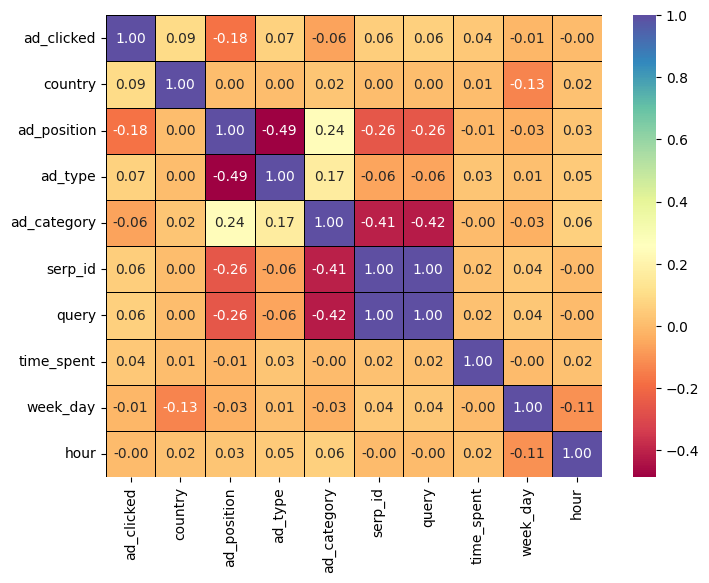

In [164]:
# pip3 install matplotlib
import matplotlib.pyplot as plt
# pip3 install seaborn
import seaborn as sns

# Create correlation matrix for features
features_df = dataset[["ad_clicked", "country", "ad_position", "ad_type", "ad_category", "serp_id", "query", "time_spent", "week_day", "hour"]]
feature_corr = features_df.corr(numeric_only=True)

# Display correlation matrix
display(feature_corr)

# Plot correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(feature_corr, annot=True, fmt='0.2f', linewidths=0.5, linecolor='Black', cmap='Spectral')
plt.show()

Having two parameters with a correlation of 1 can lead to multicollinearity issues when building a predictive model. Multicollinearity occurs when two or more independent variables are highly correlated with each other. This can cause issues in interpreting the model coefficients and can affect the stability and reliability of the model.

In such cases, it's often necessary to remove one of the highly correlated features to address multicollinearity.

In [165]:
dataset = dataset.drop("serp_id", axis=1)

## 3.3 Correlation Between Features And Target

If two parameters have a correlation of 1 with the target variable (ad_clicked), it means they are highly correlated and have a strong linear relationship with the target variable. This suggests that these parameters are good predictors of whether an ad will be clicked or not.

In [166]:
# Calculate the correlation of features to target variable
features_df = dataset[["ad_clicked", "country", "ad_position", "ad_type", "ad_category", "query", "time_spent", "week_day", "hour"]]
corr_to_target = features_df.corr(numeric_only=True)['ad_clicked']

# Show results in Descending order
cor_matrix_df = pd.DataFrame(corr_to_target.abs()).sort_values( 'ad_clicked', ascending=False)
cor_matrix_df.drop('ad_clicked', axis=0, inplace=True)
cor_matrix_df.rename(columns={'ad_clicked':'Corr'}, inplace=True)
cor_matrix_df

,Corr
ad_position,0.177069
country,0.093932
ad_type,0.069452
ad_category,0.063096
query,0.060100
time_spent,0.037232
week_day,0.011474
hour,0.001041


Since the visit time according to calculations has very little relationship with the target, it is better to remove this parameter.

In [167]:
dataset = dataset.drop("hour", axis=1)

## 3.4 Mutual Information
Mutual information is a measure of the amount of information obtained about one random variable through the other random variable. It measures the amount of information gained about one variable through the other variable.

In the context of feature selection, mutual information can be used to measure the dependency between a feature and the target variable. Features with high mutual information are considered to be more informative for predicting the target variable.

Two benefits to using Mutual Information as feature selector:
- The MI is model neutral, which means the solution can be applied to various kinds of ML models.
- MI solution is fast. 
https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8

In our project, we can use mutual information to select the most relevant features for predicting whether an ad will be clicked or not.

In [168]:
from sklearn.feature_selection import mutual_info_classif

# Selecting features and target variable
df = dataset[["ad_clicked","country","ad_position","ad_type","ad_category","query","time_spent", "week_day"]]
X = df.drop('ad_clicked', axis=1)  # Features
y = df['ad_clicked']  # Target variable

# Calculate mutual information
mutual_info = mutual_info_classif(X, y)

# Create a DataFrame to display mutual information scores
mutual_info_df = pd.DataFrame(mutual_info, index=X.columns, columns=['Mutual Information'])
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)

# Display mutual information scores
print(mutual_info_df)

             Mutual Information
query                  0.020649
ad_category            0.014293
country                0.012989
time_spent             0.012777
ad_position            0.009130
ad_type                0.000000
week_day               0.000000


This code will calculate the mutual information between each feature and the target variable (ad_clicked) and display the mutual information scores for each feature. Features with higher mutual information scores are more informative for predicting whether an ad will be clicked or not.

In [169]:
dataset = dataset.drop("ad_type", axis=1)

----

# 4. Machine Learning

In this section, we applied several machine learning models to predict whether a user will click on an advertisement based on their behavior on the website. The dataset was preprocessed to handle missing values, encode categorical variables, and address class imbalance.

## 4.1 Functions

We have defined the useful functions that we need in the following sections here.

- ### `Confusion plot function`

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

[[TN  FP]
 [FN  TP]]

TN, FP, FN, and TP represent the counts of true negatives, false positives, false negatives, and true positives, respectively.

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def confusion_plot(y_true, y_pred):
    # Assuming y_true and y_pred are your actual and predicted binary labels
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix as a heatmap
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


- ### `AUC curve plot function`

AUC (Area Under the Curve) is a popular metric used to evaluate the performance of a classification model. The ROC (Receiver Operating Characteristic) curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) for different threshold values. AUC represents the area under the ROC curve.

AUC can be calculated using the trapezoidal rule or by summing the areas of individual trapezoids formed by adjacent points on the ROC curve.

In [171]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def AUC_plot(y_true, y_scores, curve_func):
    # Assuming y_true and y_scores are your actual binary labels and predicted probabilities
    precision, recall, _ = curve_func(y_true, y_scores)
    auc_score = auc(recall, precision)

    # Plot precision-recall curve
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_score:.2f})', color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()


## 4.2 One Hot Encoding
Converting categorical parameters to dummy variables (also known as one-hot encoding) is necessary because most machine learning algorithms, including logistic regression, support numerical input only.

Here's why we convert categorical parameters to dummy variables:

1. `Numeric Representation:` Machine learning algorithms work with numerical data. By converting categorical variables into dummy variables, we transform them into a numeric format that can be used for modeling.

2. `Preventing Bias:` Converting categorical variables to numerical ones prevents the algorithm from assigning any ordinal relationship to the categories. For example, if we have a categorical variable like "color" with categories "red", "blue", and "green", converting it to dummy variables ensures that the model doesn't interpret "green" as higher or lower than "red" or "blue".

3. `Improved Model Performance:` By converting categorical variables to dummy variables, we can include them as features in our model. This can improve the performance of the model, as it allows the algorithm to understand and utilize the categorical information more effectively.

4. `Interpretability:` Dummy variables make it easier to interpret the coefficients of categorical variables in the model output. Each dummy variable represents a category, and the coefficient associated with it represents the effect of that category on the target variable.

Although we had previously changed the categorical values to numbers, but according to the above explanation, we found it better to convert them to dummies.

In [172]:
dataset_dummies = dataset
dataset_dummies = pd.get_dummies(data=dataset, columns=["country","ad_category","query"])

## 4.3 Data Train/Test Split

In machine learning, it's essential to evaluate the performance of the trained model on unseen data to assess its generalization ability. The train/test split is a common technique used to achieve this.

1. Training Data

2. Testing Data

3. Splitting Data

In [173]:
from sklearn.model_selection import train_test_split

y = dataset_dummies["ad_clicked"]
X = dataset_dummies.drop("ad_clicked", axis=1)

X = X.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_trainVal, X_testVal, y_trainVal, y_testVal  = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f'Shape of features data set for ML models => {X.shape}')
print(f'Shape of target for ML models => {y.shape}')

Shape of features data set for ML models => (2418, 273)
Shape of target for ML models => (2418,)


In [174]:
# pip3`` install imbalanced-learn
# from imblearn.over_sampling import SMOTE

# # Instantiate SMOTE
# smote = SMOTE(random_state=42)

# # Resample the dataset
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Check the class distribution after resampling
# print("After SMOTE:")
# print(pd.Series(y_resampled).value_counts())
# X_resampled.head(5)


## 4.4 Data Scaling

Scaling the data is a crucial preprocessing step in machine learning for several reasons:

1. **`Consistent Scale:`** Features with different scales might cause issues during model training. By scaling the features, we ensure that all features have the same scale, which can improve the convergence speed of some machine learning algorithms.

2. **`Preventing Dominance:`** Features with larger scales might dominate those with smaller scales. Scaling prevents this dominance and ensures that each feature contributes equally to the model training process.

3. **`Regularization:`** Some machine learning algorithms, such as gradient descent-based optimization algorithms, are sensitive to the scale of the input features. Scaling the features can help these algorithms converge more quickly.

4. **`Interpretability:`** Scaling does not change the relationship between features, but it can make the interpretation of coefficients or feature importance more intuitive.

In our case, we used ***StandardScaler*** from scikit-learn to scale our features. It standardizes features by removing the mean and scaling to unit variance.

***Since scaling the data should only be implemented on numerical parameters, we only applied it to the time spent parameter.***

In [175]:
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler1 = StandardScaler()
X_train_scaled = scaler1.fit_transform(X_train)
X_test_scaled = scaler1.transform(X_test)

scaler2 = StandardScaler()
X_trainVal_scaled = scaler2.fit_transform(X_trainVal)
X_testVal_scaled = scaler2.transform(X_testVal)

## 4.5 Naive Bayes 

Naive Bayes is a family of probabilistic algorithms based on Bayes' Theorem with the "naive" assumption of independence between every pair of features. Despite this simplifying assumption, Naive Bayes classifiers have been very successful in many real-world situations, famously in text classification problems such as spam filtering.

**`Advantages`**
- Naive Bayes is simple and easy to implement.
- It performs well in many complex real-world situations.
- It requires a small amount of training data to estimate the necessary parameters.

**`Limitations`**
- Naive Bayes assumes that features are independent, which is not always the case in real-world data.
- It can be outperformed by more complex models.
- It's sensitive to the presence of irrelevant features.

In [176]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# print(confusion_matrix(y_test, y_pred))


Accuracy: 0.3037190082644628

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.14      0.24       387
           1       0.22      0.97      0.36        97

    accuracy                           0.30       484
   macro avg       0.58      0.55      0.30       484
weighted avg       0.80      0.30      0.26       484



Given these metrics, the model's performance seems to be quite low. The accuracy is only 28.92%, which means the model correctly predicts the outcome for only 28.92% of the samples. Additionally, the precision is 13.41%, which indicates that among the instances predicted as positive, only 13.41% are actually positive.

However, the recall is 85.25%, meaning that the model correctly identifies 85.25% of the positive instances.

The low precision might be a concern, as the model seems to have a high rate of false positives (335). Depending on the context, this is unacceptable.

So, while the model's recall is relatively good, its precision and overall accuracy are quite low.

In conclusion, the result is not considered good, and further optimization or a different approach might be necessary.

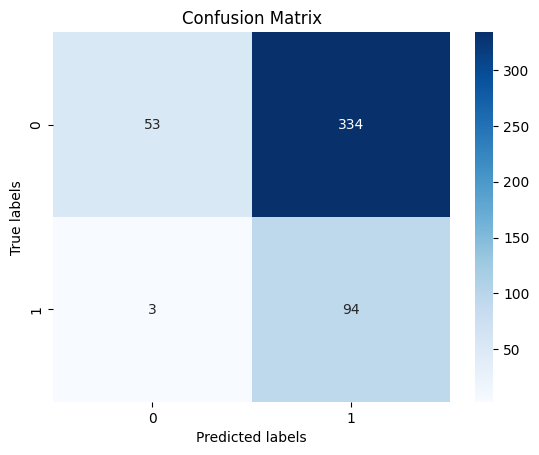

In [177]:
confusion_plot(y_test, y_pred)

## 4.6 Random Forest Classifier

Random Forest is a popular ensemble learning method used for both classification and regression tasks. It operates by constructing a multitude of decision trees during training time and outputting the mode of the classes (classification) or the average prediction (regression) of the individual trees.

In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initializing the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_classifier.fit(X_train_scaled, y_train)

# Making predictions
y_pred = rf_classifier.predict(X_test_scaled)


The random forest model, as shown below , with a prediction accuracy of 82% on training data.  

In [179]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8285123966942148

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       387
           1       0.68      0.27      0.39        97

    accuracy                           0.83       484
   macro avg       0.76      0.62      0.64       484
weighted avg       0.81      0.83      0.80       484



The high precision (0.83) and recall (0.98) for class 0 indicate that the model performs well in identifying cases where the customer did not click on the advertisement. However, the lower precision (0.71) and recall (0.21) for class 1 suggest that the model does not perform as well in identifying cases where the customer clicked on the advertisement.

In general, a good result would be one where both precision and recall are high for all classes. However, the definition of "good" can vary depending on the specific requirements of your project and the consequences of false positives and false negatives.

So, while the model performs well in identifying cases where the customer did not click on the advertisement, it could be improved in identifying cases where the customer clicked on the advertisement.

In conclusion, the result is good in terms of identifying cases where the customer did not click on the advertisement, but there is room for improvement in identifying cases where the customer clicked on the advertisement.

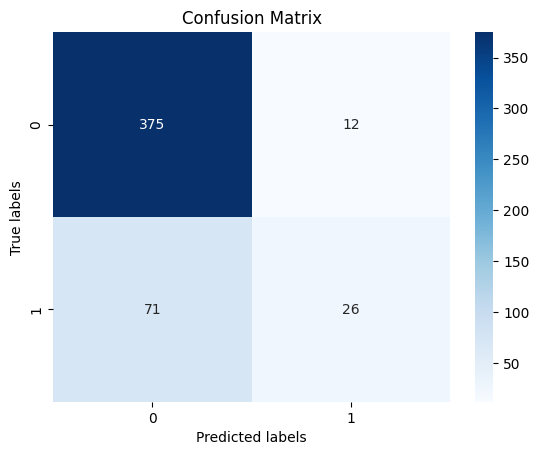

In [180]:
confusion_plot(y_test, y_pred)

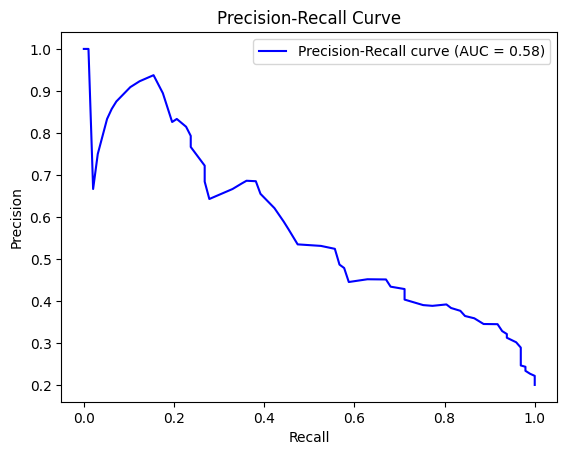

In [181]:
from sklearn.metrics import precision_recall_curve

# Calculate y scores
y_scores = rf_classifier.predict_proba(X_test_scaled)[:, 1]
AUC_plot(y_test, y_scores, precision_recall_curve)

## 4.7 Logistic Regression Model

Logistic regression is a statistical method used for binary classification tasks. Unlike linear regression, which predicts continuous values, logistic regression predicts the probability of an instance belonging to a particular class. It models the probability of the default class (usually labeled as 1) using the logistic function, also known as the sigmoid function.

In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
logestic_model = LogisticRegression()

# Train the model
logestic_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logestic_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       387
           1       0.32      0.22      0.26        97

    accuracy                           0.75       484
   macro avg       0.57      0.55      0.55       484
weighted avg       0.72      0.75      0.73       484



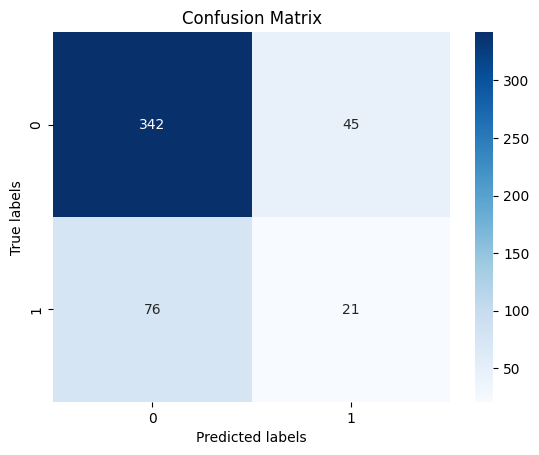

In [183]:
confusion_plot(y_test, y_pred)

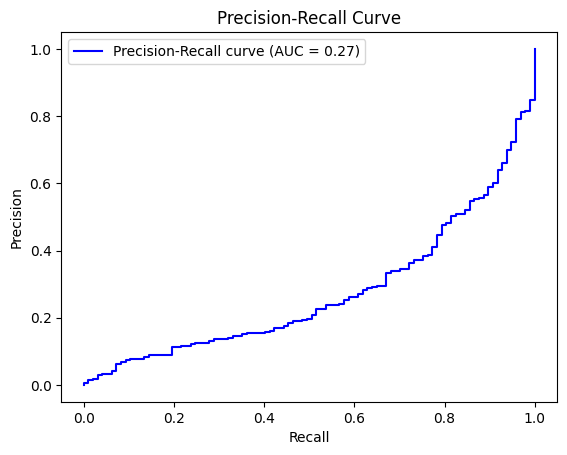

In [184]:
from sklearn.metrics import roc_curve

# Calculate y scores
y_scores = logestic_model.predict_proba(X_test_scaled)[:, 1]
AUC_plot(y_test, y_scores, roc_curve)

## 4.8 Support Vector Regression (SVR) 

Support Vector Regression (SVR) is a type of support vector machine (SVM) algorithm that is used for regression analysis. Similar to SVM for classification, SVR is based on the concept of finding a hyperplane that best fits the data. However, instead of finding the hyperplane that best separates the classes, SVR finds the hyperplane that best fits the data points within a specified margin, called ε-insensitive tube.

In this code, we implement a Support Vector Machine (SVM) model using the sigmoid kernel for binary classification. SVMs are powerful supervised learning models used for classification and regression tasks. The sigmoid kernel is particularly useful when the data is not linearly separable.

In [185]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Create SVC model
model = SVC(kernel='sigmoid')

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Training Accuracy: 0.7523267838676319
Test Accuracy: 0.7768595041322314
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.87       387
           1       0.08      0.01      0.02        97

    accuracy                           0.78       484
   macro avg       0.44      0.49      0.45       484
weighted avg       0.65      0.78      0.70       484



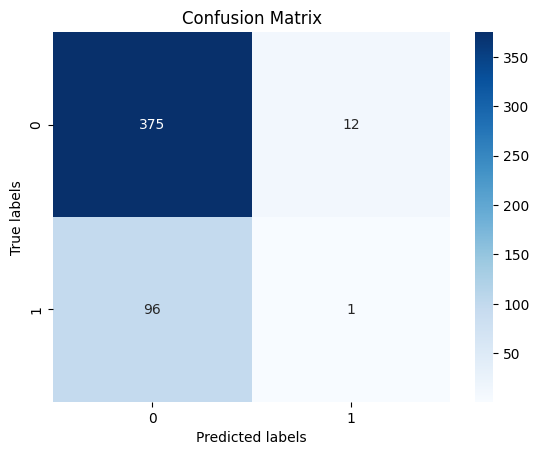

In [186]:
confusion_plot(y_test, y_test_pred)

## 4.9 Convolutional Neural Network Model

A Convolutional Neural Network (CNN) is a type of deep learning model that is widely used for image classification, object detection, and other tasks related to image analysis.

Structure of a CNN
1. Convolutional Layers: These layers consist of a set of filters (kernels) that are convolved with the input data to produce feature maps. Each filter captures different features from the input image.

2. Pooling Layers: Pooling layers are used to reduce the spatial dimensions of the feature maps while retaining important information. The most common type of pooling is max pooling, where the maximum value within a small window is retained.

3. Fully Connected Layers: After several convolutional and pooling layers, the feature maps are flattened and passed through one or more fully connected layers. These layers act as a classifier and make predictions based on the features extracted by the convolutional layers.

4. Activation Functions: Activation functions introduce non-linearity to the model. Common activation functions include ReLU (Rectified Linear Unit) and Sigmoid.

***in this project :***

- We create a Sequential model.

- We add two convolutional layers with ReLU activation and max pooling layers to extract features from the input images.

- We add a flatten layer to convert the 2D features into a 1D vector.

- We add a dense layer with ReLU activation and a dropout layer to prevent overfitting.

- Finally, we add an output layer with one neuron and a sigmoid activation function for binary classification.


In [187]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import backend 
import tensorflow as tf

tf.random.set_seed(42)
backend.clear_session()


# Reshape the input data to 3D (batch_size, timesteps, input_dim)
X_trainVal_reshaped = X_trainVal_scaled.reshape(X_trainVal_scaled.shape[0], X_trainVal_scaled.shape[1], 1)
X_testVal_reshaped = X_testVal_scaled.reshape(X_testVal_scaled.shape[0], X_testVal_scaled.shape[1], 1)

# Define input shape
input_shape = (X_trainVal_reshaped.shape[1], X_trainVal_reshaped.shape[2])

# Create CNN model     , input_shape=(X_trainVal_reshaped.shape[1], 1))
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checking = ModelCheckpoint('my_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_trainVal_reshaped, y_trainVal, epochs=10, batch_size=32, validation_data=(X_testVal_reshaped, y_testVal), callbacks=[early_stop, checking])

########## Do predictions on Training and Test Data sets and calculate metrics #########
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


Epoch 1/10
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7257 - loss: 0.6230
Epoch 1: val_accuracy improved from -inf to 0.76653, saving model to my_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7266 - loss: 0.6227 - val_accuracy: 0.7665 - val_loss: 0.5573
Epoch 2/10
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7645 - loss: 0.5111
Epoch 2: val_accuracy did not improve from 0.76653
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7646 - loss: 0.5117 - val_accuracy: 0.7541 - val_loss: 0.5560
Epoch 3/10
43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7942 - loss: 0.4634
Epoch 3: val_accuracy did not improve from 0.76653
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7938 - loss: 0.4646 - val_accuracy: 0.7500 - val_loss: 0.5566
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7948 - loss: 0.4367
Epoch 4: val_accuracy did not improve from 0.76653
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7949 - loss: 0.4368 -

In [188]:
# Evaluate the model
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7801 - loss: 0.5058 
Test Accuracy: 0.7954545617103577
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       387
           1       0.00      0.00      0.00        97

    accuracy                           0.80       484
   macro avg       0.40      0.50      0.44       484
weighted avg       0.64      0.80      0.71       484



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

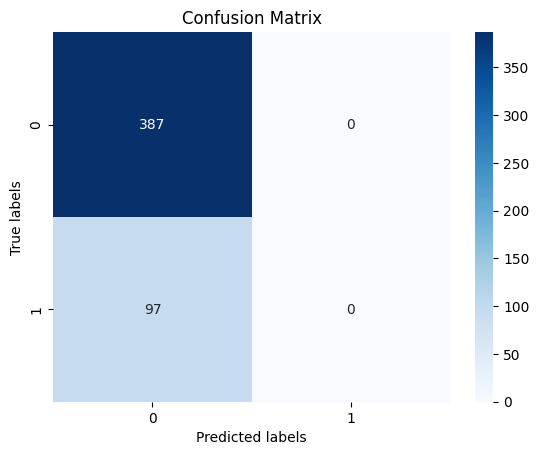

In [189]:
confusion_plot(y_test, y_test_pred)

- ### `Plot Learning Curve`
In this project, we implemented a learning curve plot to visualize the performance of our machine learning model. A learning curve shows the training and validation scores (e.g., accuracy, loss) of a model on the training dataset as a function of the number of training examples. This helps us understand how well our model is learning as we increase the size of the training dataset.

To create the learning curve, we used the learning_curve function from scikit-learn. However, since our model is implemented using Keras, we encountered an error because the Sequential model does not have a score method required by the learning_curve function.

To resolve this issue, we modified the code to use the history object returned by the fit method of our Keras model. The history object contains the training and validation metrics for each epoch. We then plotted the training and validation accuracy against the number of epochs using matplotlib.

By visualizing the learning curve, we gained insights into how well our model is learning from the training data and whether it is overfitting or underfitting. This helps us make informed decisions about model training and optimization.

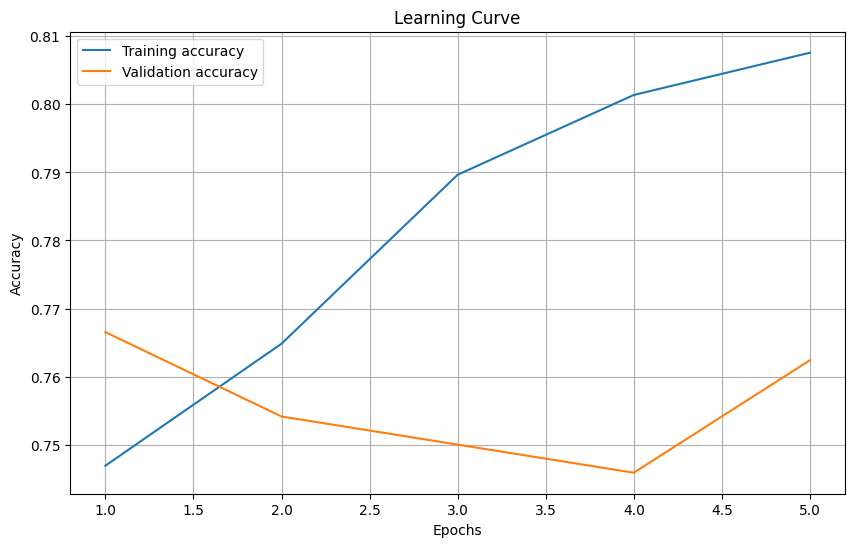

In [190]:
import matplotlib.pyplot as plt

train_scores = history.history['accuracy']
validation_scores = history.history['val_accuracy']
epochs = range(1, len(train_scores) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_scores, label='Training accuracy')
plt.plot(epochs, validation_scores, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


----
# 5. Evaluation

In this project i use 5 different method to predict the target:

1. Naive Bayes
2. Random Forest Classifier
3. Logistic Regression Model
4. Support Vector Regression (SVR) 
5. Convolutional Neural Network Model

----
# 6. Generate Image

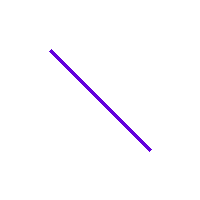

In [191]:
from PIL import Image, ImageDraw

# Create a new image with white background
width, height = 200, 200
img = Image.new("RGB", (width, height), "white")

# Draw a line
draw = ImageDraw.Draw(img)
draw.line([(50, 50), (150, 150)], fill=(100,0,220), width=3)

img

----
## 6. References

- Keras API reference / Optimizers(https://keras.io/api/optimizers/)

- Building an Ad Click Prediction Machine Learning System: Problem Statement and Metrics (https://www.linkedin.com/pulse/building-ad-click-prediction-machine-learning-system-problem-shivam-s-1wvjf)

- Predicting Click Behavior Based on Machine Learning Models (https://www.researchgate.net/publication/370570414_Predicting_Click_Behavior_Based_on_Machine_Learning_Models)

- What is Mutual Information? (https://quantdare.com/what-is-mutual-information/)